In [ ]:
pip install pandas scikit-learn spacy nltk

In [ ]:
!pip install ipywidgets

In [ ]:
pip install dataframe-image

In [ ]:
# For spacy, we need to download language models for French and Spanish
!python -m spacy download fr_core_news_sm
!python -m spacy download es_core_news_sm

In [24]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
from sklearn.model_selection import train_test_split
import string
import nltk
from nltk.stem import WordNetLemmatizer
import spacy
from tqdm.auto import tqdm
import torch
from torch.utils.data import DataLoader
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

### Data Preparation for Cross-Lingual Evaluation

In the context of cross-lingual evaluation, where models are trained and tested on distinct linguistic datasets without shared content, we can use the datasets as they are because there is no leakage or overlapping problem. This allows for straightforward dataset handling, ideal for evaluating model performance across different languages.

#### Problem Statement
Handling multiple language datasets, such as `English`, `French`, and `Spanish`, typically requires ensuring that training data from one language does not contaminate the test sets from others. In this case, however, the separate nature of each dataset precludes the possibility of such contamination.

#### Solution Approach
The `split_and_prepare_datasets_cross_lingual` function adapts to these circumstances by:
1. **Dataset Splitting**: Directly splitting the primary training dataset (`df_train`) into training, validation, and test subsets using predefined ratios of 70%, 10%, and 20% respectively. This straightforward division guarantees that the model evaluations are based on distinct sets.
2. **Simplifying Data Handling**: Since the datasets are inherently non-overlapping, there is no need for intricate checks against data leakage, significantly simplifying the preparation process.
3. **Maintaining Dataset Integrity**: The function utilizes test datasets (`df_test_1` and `df_test_2`) as they are provided, maintaining their original composition which is crucial for valid cross-lingual assessments.
4. **Efficient Setup**: Outputs well-structured training, validation, and test datasets, allowing for seamless integration into training and evaluation pipelines.

This method streamlines dataset preparation for cross-lingual NLP tasks, ensuring that models are trained and evaluated in a controlled and unbiased environment.

### Usage
Implement the `split_and_prepare_datasets_cross_lingual` function, load your distinct language datasets, and apply the function to partition each dataset properly. This approach is crucial for training robust models capable of understanding and performing well across different linguistic contexts.

In [7]:
# Load Spacy models for French and Spanish
nlp_fr = spacy.load('fr_core_news_sm')
nlp_es = spacy.load('es_core_news_sm')

# Ensure NLTK resources are downloaded (needed for lemmatization)
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

#---------------------------------------------------------------------

def preprocess_text(text, lower=True, remove_punctuation=True, lemmatize=True, language='en'):
    if lower:
        text = text.lower()
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    if lemmatize:
        if language == 'en':
            lemmatizer = WordNetLemmatizer()
            word_list = nltk.word_tokenize(text)
            text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
        elif language == 'fr':
            doc = nlp_fr(text)
            text = ' '.join([token.lemma_ for token in doc])
        elif language == 'es':
            doc = nlp_es(text)
            text = ' '.join([token.lemma_ for token in doc])
    return text

#---------------------------------------------------------------------

def apply_preprocessing(df, text_column='text', language='en'):
    df[text_column] = df[text_column].apply(lambda x: preprocess_text(x, language=language))
    return df

#---------------------------------------------------------------------

def split_and_prepare_datasets_cross_lingual(df_train, df_test_1, df_test_2):
    # Split the training dataset into train, validation, and test sets
    train_ratio = 0.70
    validation_ratio = 0.10
    test_ratio = 0.20
    # Calculate the test and validation sizes based on the remaining dataset after initial training split
    test_size = test_ratio / (test_ratio + validation_ratio)
    
    # First split to separate out the training data
    df_train_split, df_temp = train_test_split(df_train, test_size=(1 - train_ratio), stratify=df_train['write_by'], random_state=42)
    
    # Second split to separate out the validation and test data
    df_val_split, df_test_split = train_test_split(df_temp, test_size=test_size, stratify=df_temp['write_by'], random_state=42)

    # Return datasets without modifying the external test sets
    df_test_1_final = df_test_1
    df_test_2_final = df_test_2
    
    return df_train_split, df_val_split, df_test_split, df_test_1_final, df_test_2_final
    

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# %%time

# Define paths
path_colab = '/content/drive/MyDrive/Colab Notebooks/3_Final_Dataset/'
path_notebook = 'C:/Users/amirm/Desktop/MONASH/Thesis/Working/Prepare/Code/3_Final_Dataset/'

# Toggle this to switch between Colab and local notebook paths
use_colab = True

# Set the base path based on the flag
base_path = path_colab if use_colab else path_notebook

#---------------------------------------------------------------------

# Helper function to read datasets
def load_dataset(file_name):
    return pd.read_csv(base_path + file_name)
#---------------------------------------------------------------------

# Helper function to preprocess datasets
def preprocess_dataset(df, language):
    return apply_preprocessing(df, language=language)

#---------------------------------------------------------------------

# English datasets
df_en_mistral = load_dataset('English_(open-mistral-7b).csv')
df_en_gemini = load_dataset('English_(gemini-pro).csv')
df_en_gpt = load_dataset('English_(gpt-3.5-turbo-0125).csv')

#---------------------------------------------------------------------

# French datasets
df_fr_mistral = load_dataset('French_(open-mistral-7b).csv')
df_fr_gemini = load_dataset('French_(gemini-pro).csv')
df_fr_gpt = load_dataset('French_(gpt-3.5-turbo-0125).csv')

#---------------------------------------------------------------------

# Spanish datasets
df_es_mistral = load_dataset('Spanish_(open-mistral-7b).csv')
df_es_gemini = load_dataset('Spanish_(gemini-pro).csv')
df_es_gpt = load_dataset('Spanish_(gpt-3.5-turbo-0125).csv')


In [ ]:
# Preprocess English datasets
df_en_mistral_preprocessed = preprocess_dataset(df_en_mistral, 'en')
df_en_gemini_preprocessed = preprocess_dataset(df_en_gemini, 'en')
df_en_gpt_preprocessed = preprocess_dataset(df_en_gpt, 'en')

#---------------------------------------------------------------------

# Preprocess French datasets
df_fr_mistral_preprocessed = preprocess_dataset(df_fr_mistral, 'fr')
df_fr_gemini_preprocessed = preprocess_dataset(df_fr_gemini, 'fr')
df_fr_gpt_preprocessed = preprocess_dataset(df_fr_gpt, 'fr')

#---------------------------------------------------------------------

# Preprocess Spanish datasets
df_es_mistral_preprocessed = preprocess_dataset(df_es_mistral, 'es')
df_es_gemini_preprocessed = preprocess_dataset(df_es_gemini, 'es')
df_es_gpt_preprocessed = preprocess_dataset(df_es_gpt, 'es')

In [ ]:
# Call the function to split the datasets for Gemini
df_en_gemini_train, df_en_gemini_val, df_en_gemini_internaltest, df_fr_gemini_externaltest, df_es_gemini_externaltest = split_and_prepare_datasets_cross_lingual(df_en_gemini, df_fr_gemini, df_es_gemini)
df_fr_gemini_train, df_fr_gemini_val, df_fr_gemini_internaltest, df_en_gemini_externaltest, df_es_gemini_externaltest = split_and_prepare_datasets_cross_lingual(df_fr_gemini, df_en_gemini, df_es_gemini)
df_es_gemini_train, df_es_gemini_val, df_es_gemini_internaltest, df_fr_gemini_externaltest, df_en_gemini_externaltest = split_and_prepare_datasets_cross_lingual(df_es_gemini, df_fr_gemini, df_en_gemini)

#---------------------------------------------------------------------

# Call the function to split the datasets for GPT
df_en_gpt_train, df_en_gpt_val, df_en_gpt_internaltest, df_fr_gpt_externaltest, df_es_gpt_externaltest = split_and_prepare_datasets_cross_lingual(df_en_gpt, df_fr_gpt, df_es_gpt)
df_fr_gpt_train, df_fr_gpt_val, df_fr_gpt_internaltest, df_en_gpt_externaltest, df_es_gpt_externaltest = split_and_prepare_datasets_cross_lingual(df_fr_gpt, df_en_gpt, df_es_gpt)
df_es_gpt_train, df_es_gpt_val, df_es_gpt_internaltest, df_fr_gpt_externaltest, df_en_gpt_externaltest = split_and_prepare_datasets_cross_lingual(df_es_gpt, df_fr_gpt, df_en_gpt)

#---------------------------------------------------------------------

# Call the function to split the datasets for Mistarl
df_en_mistral_train, df_en_mistral_val, df_en_mistral_internaltest, df_fr_mistral_externaltest, df_es_mistral_externaltest = split_and_prepare_datasets_cross_lingual(df_en_mistral, df_fr_mistral, df_es_mistral)
df_fr_mistral_train, df_fr_mistral_val, df_fr_mistral_internaltest, df_en_mistral_externaltest, df_es_mistral_externaltest = split_and_prepare_datasets_cross_lingual(df_fr_mistral, df_en_mistral, df_es_mistral)
df_es_mistral_train, df_es_mistral_val, df_es_mistral_internaltest, df_fr_mistral_externaltest, df_en_mistral_externaltest = split_and_prepare_datasets_cross_lingual(df_es_mistral, df_fr_mistral, df_en_mistral)


In [ ]:
# Call the function to split the datasets for Gemini preprocessed (lower, remove_punctuation, lemmatize)
df_en_gemini_train_pre, df_en_gemini_val_pre, df_en_gemini_internaltest_pre, df_fr_gemini_externaltest_pre, df_es_gemini_externaltest_pre = split_and_prepare_datasets_cross_lingual(df_en_gemini_preprocessed, df_fr_gemini_preprocessed, df_es_gemini_preprocessed)
df_fr_gemini_train_pre, df_fr_gemini_val_pre, df_fr_gemini_internaltest_pre, df_en_gemini_externaltest_pre, df_es_gemini_externaltest_pre = split_and_prepare_datasets_cross_lingual(df_fr_gemini_preprocessed, df_en_gemini_preprocessed, df_es_gemini_preprocessed)
df_es_gemini_train_pre, df_es_gemini_val_pre, df_es_gemini_internaltest_pre, df_fr_gemini_externaltest_pre, df_en_gemini_externaltest_pre = split_and_prepare_datasets_cross_lingual(df_es_gemini_preprocessed, df_fr_gemini_preprocessed, df_en_gemini_preprocessed)

#---------------------------------------------------------------------

# Call the function to split the datasets for GPT preprocessed (lower, remove_punctuation, lemmatize)
df_en_gpt_train_pre, df_en_gpt_val_pre, df_en_gpt_internaltest_pre, df_fr_gpt_externaltest_pre, df_es_gpt_externaltest_pre = split_and_prepare_datasets_cross_lingual(df_en_gpt_preprocessed, df_fr_gpt_preprocessed, df_es_gpt_preprocessed)
df_fr_gpt_train_pre, df_fr_gpt_val_pre, df_fr_gpt_internaltest_pre, df_en_gpt_externaltest_pre, df_es_gpt_externaltest_pre = split_and_prepare_datasets_cross_lingual(df_fr_gpt_preprocessed, df_en_gpt_preprocessed, df_es_gpt_preprocessed)
df_es_gpt_train_pre, df_es_gpt_val_pre, df_es_gpt_internaltest_pre, df_fr_gpt_externaltest_pre, df_en_gpt_externaltest_pre = split_and_prepare_datasets_cross_lingual(df_es_gpt_preprocessed, df_fr_gpt_preprocessed, df_en_gpt_preprocessed)

#---------------------------------------------------------------------

# Call the function to split the datasets for Mistarl preprocessed (lower, remove_punctuation, lemmatize)
df_en_mistral_train_pre, df_en_mistral_val_pre, df_en_mistral_internaltest_pre, df_fr_mistral_externaltest_pre, df_es_mistral_externaltest_pre = split_and_prepare_datasets_cross_lingual(df_en_mistral_preprocessed, df_fr_mistral_preprocessed, df_es_mistral_preprocessed)
df_fr_mistral_train_pre, df_fr_mistral_val_pre, df_fr_mistral_internaltest_pre, df_en_mistral_externaltest_pre, df_es_mistral_externaltest_pre = split_and_prepare_datasets_cross_lingual(df_fr_mistral_preprocessed, df_en_mistral_preprocessed, df_es_mistral_preprocessed)
df_es_mistral_train_pre, df_es_mistral_val_pre, df_es_mistral_internaltest_pre, df_fr_mistral_externaltest_pre, df_en_mistral_externaltest_pre = split_and_prepare_datasets_cross_lingual(df_es_mistral_preprocessed, df_fr_mistral_preprocessed, df_en_mistral_preprocessed)


In [ ]:
# Constants
MODEL_NAME = 'xlm-roberta-base'
MAX_LEN = 512
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)

#---------------------------------------------------------------------

# Dataset Class
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

#---------------------------------------------------------------------

# Function to create data loaders
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TextDataset(
        texts=df['text'].to_numpy(),
        labels=df['label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(ds, batch_size=batch_size, num_workers=4)



In [14]:
# Function to train the model
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    total_correct = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        total_correct += torch.sum(preds == labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_correct.double() / len(data_loader.dataset), total_loss / len(data_loader.dataset)

#---------------------------------------------------------------------

# Function to evaluate the model with additional metrics
def eval_model(model, data_loader, device):
    model.eval()
    final_labels = []
    final_preds = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=None)  # No labels for prediction mode
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            # Move preds and labels to CPU for metric calculation
            final_labels.extend(labels.cpu().detach().numpy())
            final_preds.extend(preds.cpu().detach().numpy())

    # Calculate metrics
    accuracy = accuracy_score(final_labels, final_preds)
    precision = precision_score(final_labels, final_preds, average='binary')
    recall = recall_score(final_labels, final_preds, average='binary')
    f1 = f1_score(final_labels, final_preds, average='binary')

    return accuracy, precision, recall, f1


In [ ]:
# # Initialize results list
# results = []

# # Train and evaluate function
# def train_and_evaluate(train_data, val_data, internal_test_data, external_test_data_1, external_test_data_2, model_name):
#     # Create data loaders
#     train_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
#     val_loader = create_data_loader(val_data, tokenizer, MAX_LEN, BATCH_SIZE)
#     test_loader = create_data_loader(internal_test_data, tokenizer, MAX_LEN, BATCH_SIZE)
#     external_loader_1 = create_data_loader(external_test_data_1, tokenizer, MAX_LEN, BATCH_SIZE)
#     external_loader_2 = create_data_loader(external_test_data_2, tokenizer, MAX_LEN, BATCH_SIZE)

#     # Initialize model
#     model = XLMRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)
#     optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
#     total_steps = len(train_loader) * EPOCHS
#     scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#     best_val_f1 = 0.0  # Initialize the best F1 score

#     # Train model
#     for epoch in range(EPOCHS):
#         train_acc, train_loss = train_epoch(model, train_loader, optimizer, DEVICE, scheduler)
#         print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss}, Accuracy: {train_acc}')

#         # Evaluate on validation set
#         val_accuracy, val_precision, val_recall, val_f1 = eval_model(model, val_loader, DEVICE)
#         print(f'Validation Metrics - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}')

#         # Check if the current model's F1 score on the validation set is the best one so far
#         if val_f1 > best_val_f1:
#             best_val_f1 = val_f1
#             # Save the model as the best one so far
#             torch.save(model.state_dict(), f"{model_name}.bin")
#             print(f"Saved new best model with F1 score: {val_f1}")

#     # After training all epochs, load the best model for evaluation
#     model.load_state_dict(torch.load(f"{model_name}.bin"))

#     # Evaluate model
#     internal_metrics = eval_model(model, test_loader, DEVICE)
#     external_metrics_1 = eval_model(model, external_loader_1, DEVICE)
#     external_metrics_2 = eval_model(model, external_loader_2, DEVICE)

#     # Append results
#     results.append([model_name, 'Internal Test'] + list(internal_metrics))
#     results.append([model_name, 'External Test 1'] + list(external_metrics_1))
#     results.append([model_name, 'External Test 2'] + list(external_metrics_2))


# # List of dataset groups for training
# dataset_groups = [
#     ('en_mistral', df_en_mistral_train, df_en_mistral_val, df_en_mistral_internaltest, df_fr_mistral_externaltest, df_es_mistral_externaltest),
#     ('en_gemini', df_en_gemini_train, df_en_gemini_val, df_en_gemini_internaltest, df_fr_gemini_externaltest, df_es_gemini_externaltest),
#     ('en_gpt', df_en_gpt_train, df_en_gpt_val, df_en_gpt_internaltest, df_fr_gpt_externaltest, df_es_gpt_externaltest),
#     # Repeat the structure for French datasets
#     ('fr_mistral', df_fr_mistral_train, df_fr_mistral_val, df_fr_mistral_internaltest, df_en_mistral_externaltest, df_es_mistral_externaltest),
#     ('fr_gemini', df_fr_gemini_train, df_fr_gemini_val, df_fr_gemini_internaltest, df_en_gemini_externaltest, df_es_gemini_externaltest),
#     ('fr_gpt', df_fr_gpt_train, df_fr_gpt_val, df_fr_gpt_internaltest, df_en_gpt_externaltest, df_es_gpt_externaltest),
#     # Repeat the structure for Spanish datasets
#     ('es_mistral', df_es_mistral_train, df_es_mistral_val, df_es_mistral_internaltest, df_fr_mistral_externaltest, df_en_mistral_externaltest),
#     ('es_gemini', df_es_gemini_train, df_es_gemini_val, df_es_gemini_internaltest, df_fr_gemini_externaltest, df_en_gemini_externaltest),
#     ('es_gpt', df_es_gpt_train, df_es_gpt_val, df_es_gpt_internaltest, df_fr_gpt_externaltest, df_en_gpt_externaltest),
#     # # Preprocessed English datasets
#     # ('en_mistral_pre', df_en_mistral_train_pre, df_en_mistral_val_pre, df_en_mistral_internaltest_pre, df_fr_mistral_externaltest_pre, df_es_mistral_externaltest_pre),
#     # ('en_gemini_pre', df_en_gemini_train_pre, df_en_gemini_val_pre, df_en_gemini_internaltest_pre, df_fr_gemini_externaltest_pre, df_es_gemini_externaltest_pre),
#     # ('en_gpt_pre', df_en_gpt_train_pre, df_en_gpt_val_pre, df_en_gpt_internaltest_pre, df_fr_gpt_externaltest_pre, df_es_gpt_externaltest_pre),
#     # # Preprocessed French datasets
#     # ('fr_mistral_pre', df_fr_mistral_train_pre, df_fr_mistral_val_pre, df_fr_mistral_internaltest_pre, df_en_mistral_externaltest_pre, df_es_mistral_externaltest_pre),
#     # ('fr_gemini_pre', df_fr_gemini_train_pre, df_fr_gemini_val_pre, df_fr_gemini_internaltest_pre, df_en_gemini_externaltest_pre, df_es_gemini_externaltest_pre),
#     # ('fr_gpt_pre', df_fr_gpt_train_pre, df_fr_gpt_val_pre, df_fr_gpt_internaltest_pre, df_en_gpt_externaltest_pre, df_es_gpt_externaltest_pre),
#     # # Preprocessed Spanish datasets
#     # ('es_mistral_pre', df_es_mistral_train_pre, df_es_mistral_val_pre, df_es_mistral_internaltest_pre, df_fr_mistral_externaltest_pre, df_en_mistral_externaltest_pre),
#     # ('es_gemini_pre', df_es_gemini_train_pre, df_es_gemini_val_pre, df_es_gemini_internaltest_pre, df_fr_gemini_externaltest_pre, df_en_gemini_externaltest_pre),
#     # ('es_gpt_pre', df_es_gpt_train_pre, df_es_gpt_val_pre, df_es_gpt_internaltest_pre, df_fr_gpt_externaltest_pre, df_en_gpt_externaltest_pre),
# ]

# # Loop over the dataset groups and train/evaluate models
# for group in dataset_groups:
#     language_prefix, train_data, val_data, internal_test_data, external_test_data_1, external_test_data_2 = group
#     model_name = f"Cross_Lingual_{language_prefix}_XLM_RoBERTa"
#     train_and_evaluate(train_data, val_data, internal_test_data, external_test_data_1, external_test_data_2, model_name)



In [ ]:
# Initialize results list
results = []

# Train and evaluate function
def train_and_evaluate(model_name, train_data, val_data, internal_test_data, external_test_data_1, external_test_data_2, internal_test_name, external_test_name_1, external_test_name_2):
    # Create data loaders
    train_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
    val_loader = create_data_loader(val_data, tokenizer, MAX_LEN, BATCH_SIZE)
    test_loader = create_data_loader(internal_test_data, tokenizer, MAX_LEN, BATCH_SIZE)
    external_loader_1 = create_data_loader(external_test_data_1, tokenizer, MAX_LEN, BATCH_SIZE)
    external_loader_2 = create_data_loader(external_test_data_2, tokenizer, MAX_LEN, BATCH_SIZE)

    # Initialize model
    model = XLMRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    best_val_f1 = 0.0  # Initialize the best F1 score

    # Train model
    for epoch in range(EPOCHS):
        train_acc, train_loss = train_epoch(model, train_loader, optimizer, DEVICE, scheduler)
        print(f'Epoch {epoch + 1}/{EPOCHS}, Train Loss: {train_loss}, Accuracy: {train_acc}')

        # Evaluate on validation set
        val_accuracy, val_precision, val_recall, val_f1 = eval_model(model, val_loader, DEVICE)
        print(f'Validation Metrics - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}')

        # Check if the current model's F1 score on the validation set is the best one so far
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            # Save the model as the best one so far
            torch.save(model.state_dict(), f"{model_name}.bin")
            print(f"Saved new best model with F1 score: {val_f1}")

    # After training all epochs, load the best model for evaluation
    model.load_state_dict(torch.load(f"{model_name}.bin"))

    # Evaluate model
    internal_metrics = eval_model(model, test_loader, DEVICE)
    external_metrics_1 = eval_model(model, external_loader_1, DEVICE)
    external_metrics_2 = eval_model(model, external_loader_2, DEVICE)

    # Append results with specific test names
    results.append([model_name, internal_test_name] + list(internal_metrics))
    results.append([model_name, external_test_name_1] + list(external_metrics_1))
    results.append([model_name, external_test_name_2] + list(external_metrics_2))


# List of dataset groups for training
dataset_groups = [
    ('en_mistral', 'fr_mistral', 'es_mistral', df_en_mistral_train, df_en_mistral_val, df_en_mistral_internaltest, df_fr_mistral_externaltest, df_es_mistral_externaltest),
    ('en_gemini', 'fr_gemini', 'es_gemini', df_en_gemini_train, df_en_gemini_val, df_en_gemini_internaltest, df_fr_gemini_externaltest, df_es_gemini_externaltest),
    ('en_gpt', 'fr_gpt', 'es_gpt', df_en_gpt_train, df_en_gpt_val, df_en_gpt_internaltest, df_fr_gpt_externaltest, df_es_gpt_externaltest),
    # Repeat the structure for French datasets
    ('fr_mistral', 'en_mistral', 'es_mistral', df_fr_mistral_train, df_fr_mistral_val, df_fr_mistral_internaltest, df_en_mistral_externaltest, df_es_mistral_externaltest),
    ('fr_gemini', 'en_gemini', 'es_gemini', df_fr_gemini_train, df_fr_gemini_val, df_fr_gemini_internaltest, df_en_gemini_externaltest, df_es_gemini_externaltest),
    ('fr_gpt', 'en_gpt', 'es_gpt', df_fr_gpt_train, df_fr_gpt_val, df_fr_gpt_internaltest, df_en_gpt_externaltest, df_es_gpt_externaltest),
    # Repeat the structure for Spanish datasets
    ('es_mistral', 'fr_mistral', 'en_mistral', df_es_mistral_train, df_es_mistral_val, df_es_mistral_internaltest, df_fr_mistral_externaltest, df_en_mistral_externaltest),
    ('es_gemini', 'fr_gemini', 'en_gemini', df_es_gemini_train, df_es_gemini_val, df_es_gemini_internaltest, df_fr_gemini_externaltest, df_en_gemini_externaltest),
    ('es_gpt', 'fr_gpt', 'en_gpt', df_es_gpt_train, df_es_gpt_val, df_es_gpt_internaltest, df_fr_gpt_externaltest, df_en_gpt_externaltest),
]


# Loop over the dataset groups and train/evaluate models
for group in dataset_groups:
    internal_test_name, external_test_name_1, external_test_name_2, train_data, val_data, internal_test_data, external_test_data_1, external_test_data_2 = group
    model_name = f"Cross_Lingual_{internal_test_name}_XLM_RoBERTa"
    train_and_evaluate(model_name, train_data, val_data, internal_test_data, external_test_data_1, external_test_data_2, internal_test_name, external_test_name_1, external_test_name_2)


In [ ]:
# Before creating DataFrame, round the metrics in the results list
for i in range(len(results)):
    results[i][2:] = [round(metric, 3) for metric in results[i][2:]]

# Create DataFrame from results with rounded numbers
results_df = pd.DataFrame(results, columns=['Model Train On', 'Test On', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Save the results to a CSV file
results_csv_path = '/content/drive/MyDrive/Colab Notebooks/cross_lingual_evaluation_results.csv'
results_df.to_csv(results_csv_path, index=False)


In [25]:
# Later, to load the results DataFrame in another section or a different program, you can use:
results_df = pd.read_csv('cross_lingual_evaluation_results.csv')

In [26]:
# Function to modify model names
def modify_model_and_test_name(model_name):
    parts = model_name.split('_')
    new_name = ' '.join(parts)
    return new_name

In [27]:
# Function to modify model names
def modify_model_name(model_name):
    parts = model_name.split('_')
    new_name = f"{parts[2]} {parts[3]}"
    return new_name

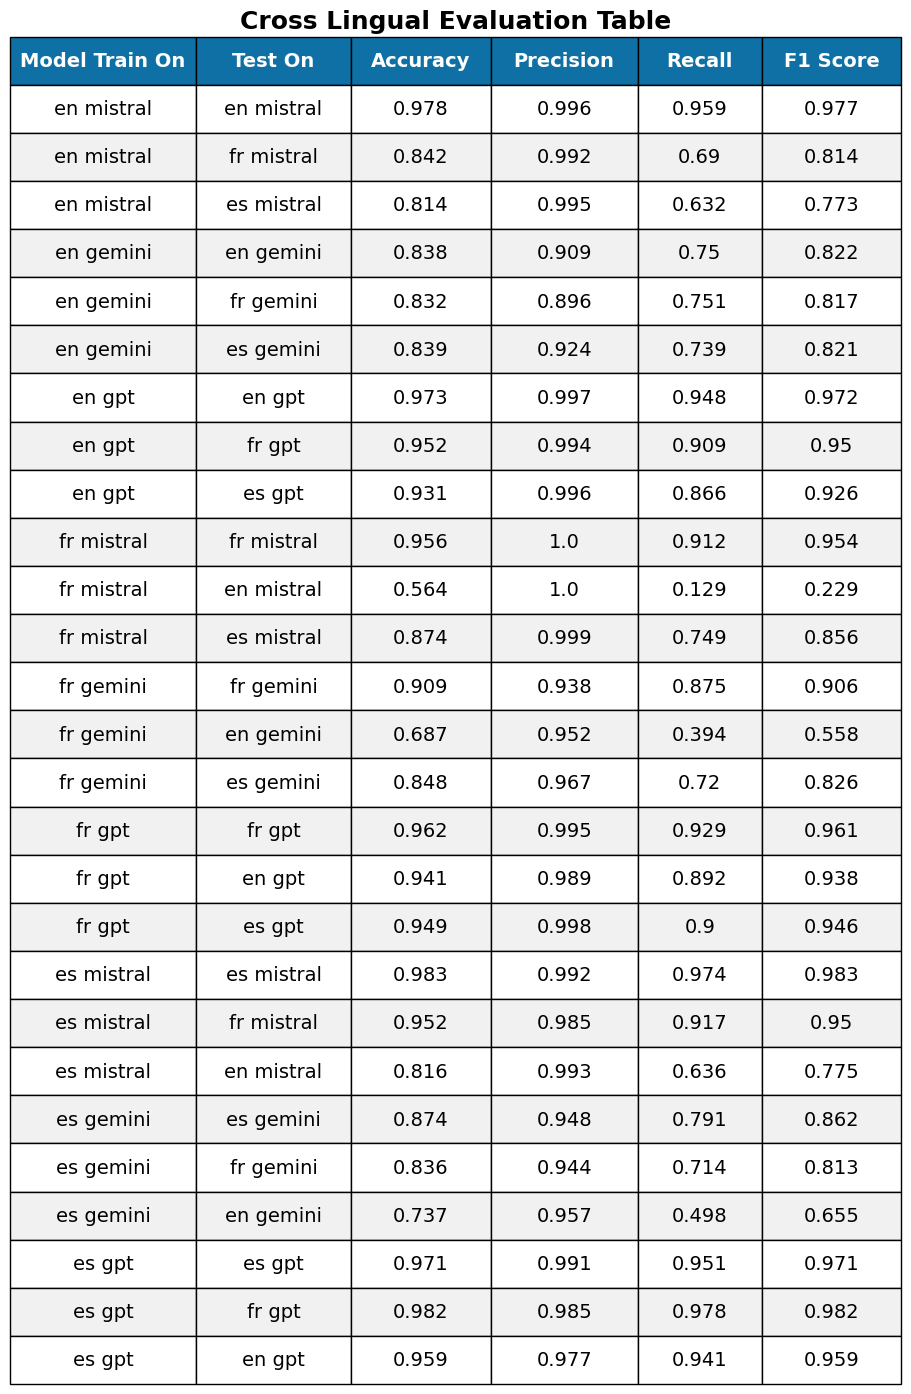

In [28]:
# Function to render a table in matplotlib and adjust column widths based on text length
def render_mpl_table(data, row_height=0.625, font_size=14,
                     header_color='#0e70a5', row_colors=['#f1f1f2', 'w'], edge_color='black',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    data['Model Train On'] = data['Model Train On'].apply(modify_model_name)
    data['Test On'] = data['Test On'].apply(modify_model_and_test_name)

    # Calculate the maximum string length for each column and apply padding
    padding = 10  # Define padding size
    col_widths = [max(data[col].apply(lambda x: len(str(x))).max(), len(
        col)) + padding for col in data.columns]
    col_widths = [x * 0.1 for x in col_widths]  # Scale factor for width

    if ax is None:
        size = (np.array([sum(col_widths), data.shape[0]+1])
                * np.array([1, row_height]))
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns,
                         colWidths=col_widths, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)  
        cell.set_text_props(ha='center')  
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])

    return ax

# Render the table
render_mpl_table(results_df, header_columns=0)
plt.title('Cross Lingual Evaluation Table', fontsize=18, weight='bold')
plt.savefig('cross_lingual_evaluation_table.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
# To download the models as zip file

import os
import zipfile
from google.colab import files

def zip_files(directory, output_zip):
    # Create a ZipFile object
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through the directory
        for root, dirs, files in os.walk(directory):
            for file in files:
                # Create complete filepath of file in directory
                filepath = os.path.join(root, file)
                # Add file to zip
                zipf.write(filepath, arcname=os.path.relpath(filepath, directory))

# Specify the directory to zip
directory_to_zip = '/content'
output_zip_file = 'content_directory.zip'

# Call the function
zip_files(directory_to_zip, output_zip_file)

# Provide a link to download the zip
files.download(output_zip_file)


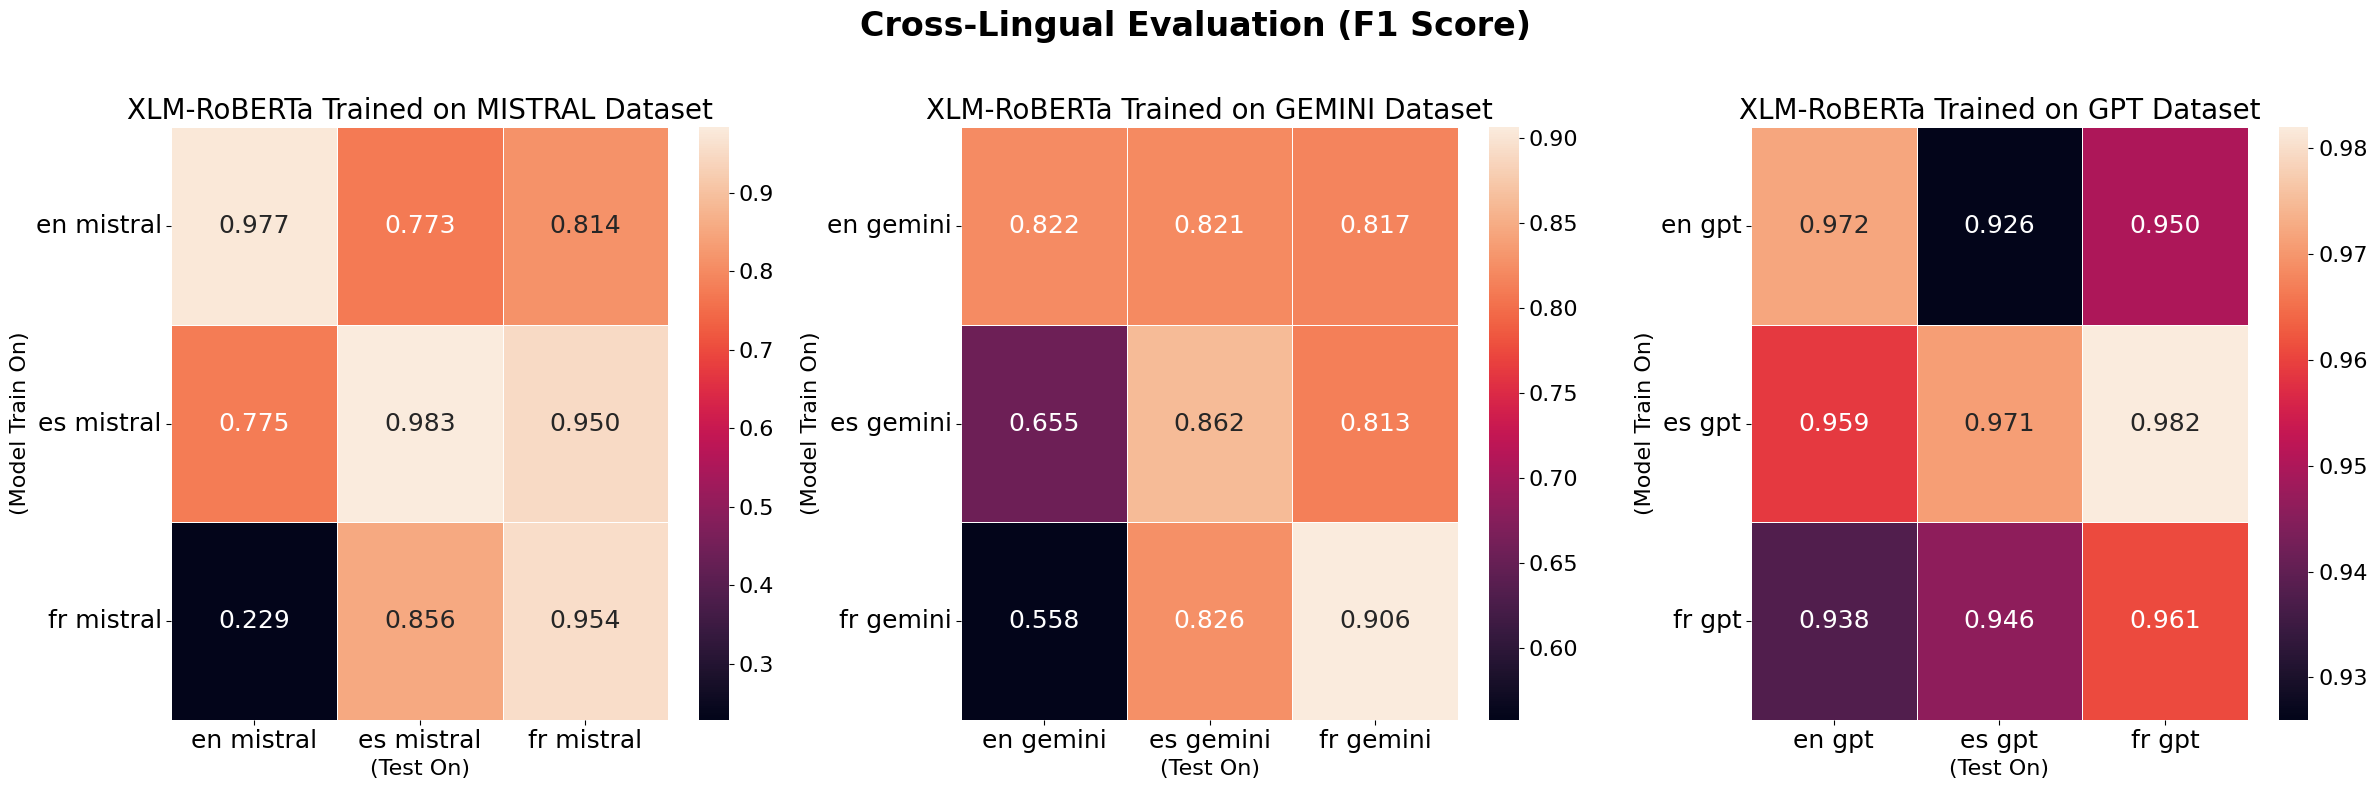

In [31]:
# Load the data from a CSV file
results_df = pd.read_csv('cross_lingual_evaluation_results.csv')

# Define a list of models assuming unique identifiers in your dataset
models = ['mistral', 'gemini', 'gpt']

# Create a custom color map from white to green
gray_green = LinearSegmentedColormap.from_list("gray_green", ["gray", "green"])


# Apply the function to the 'Model Train On' and 'Test on' column
results_df['Model Train On'] = results_df['Model Train On'].apply(modify_model_name)
results_df['Test On'] = results_df['Test On'].apply(modify_model_and_test_name)

# Create a single figure before the loop
fig = plt.figure(figsize=(24, 8))  # Adjusted size for side-by-side layout

# Add a title to the entire figure
fig.suptitle('Cross-Lingual Evaluation (F1 Score)', fontsize=24, weight='bold')

# Loop over models
for i, model in enumerate(models):
    # Filter data for the current model
    model_data = results_df[results_df['Model Train On'].str.contains(model)]
    heatmap_data = model_data.pivot(index="Model Train On", columns="Test On", values="F1 Score")

    # Add subplot to the figure created before the loop
    ax = fig.add_subplot(1, len(models), i + 1)  # Subplot for each model side by side
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", linewidths=.5, 
                annot_kws={"size": 18}, ax=ax)
    ax.set_title(f'XLM-RoBERTa Trained on {model.upper()} Dataset', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)
    ax.set_ylabel('(Model Train On)', fontsize=16)  
    ax.set_xlabel('(Test On)', fontsize=16)

    # Set colorbar properties to increase font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
plt.savefig('cross_lingual_evaluation_f1_score.png', dpi=300)
plt.show()


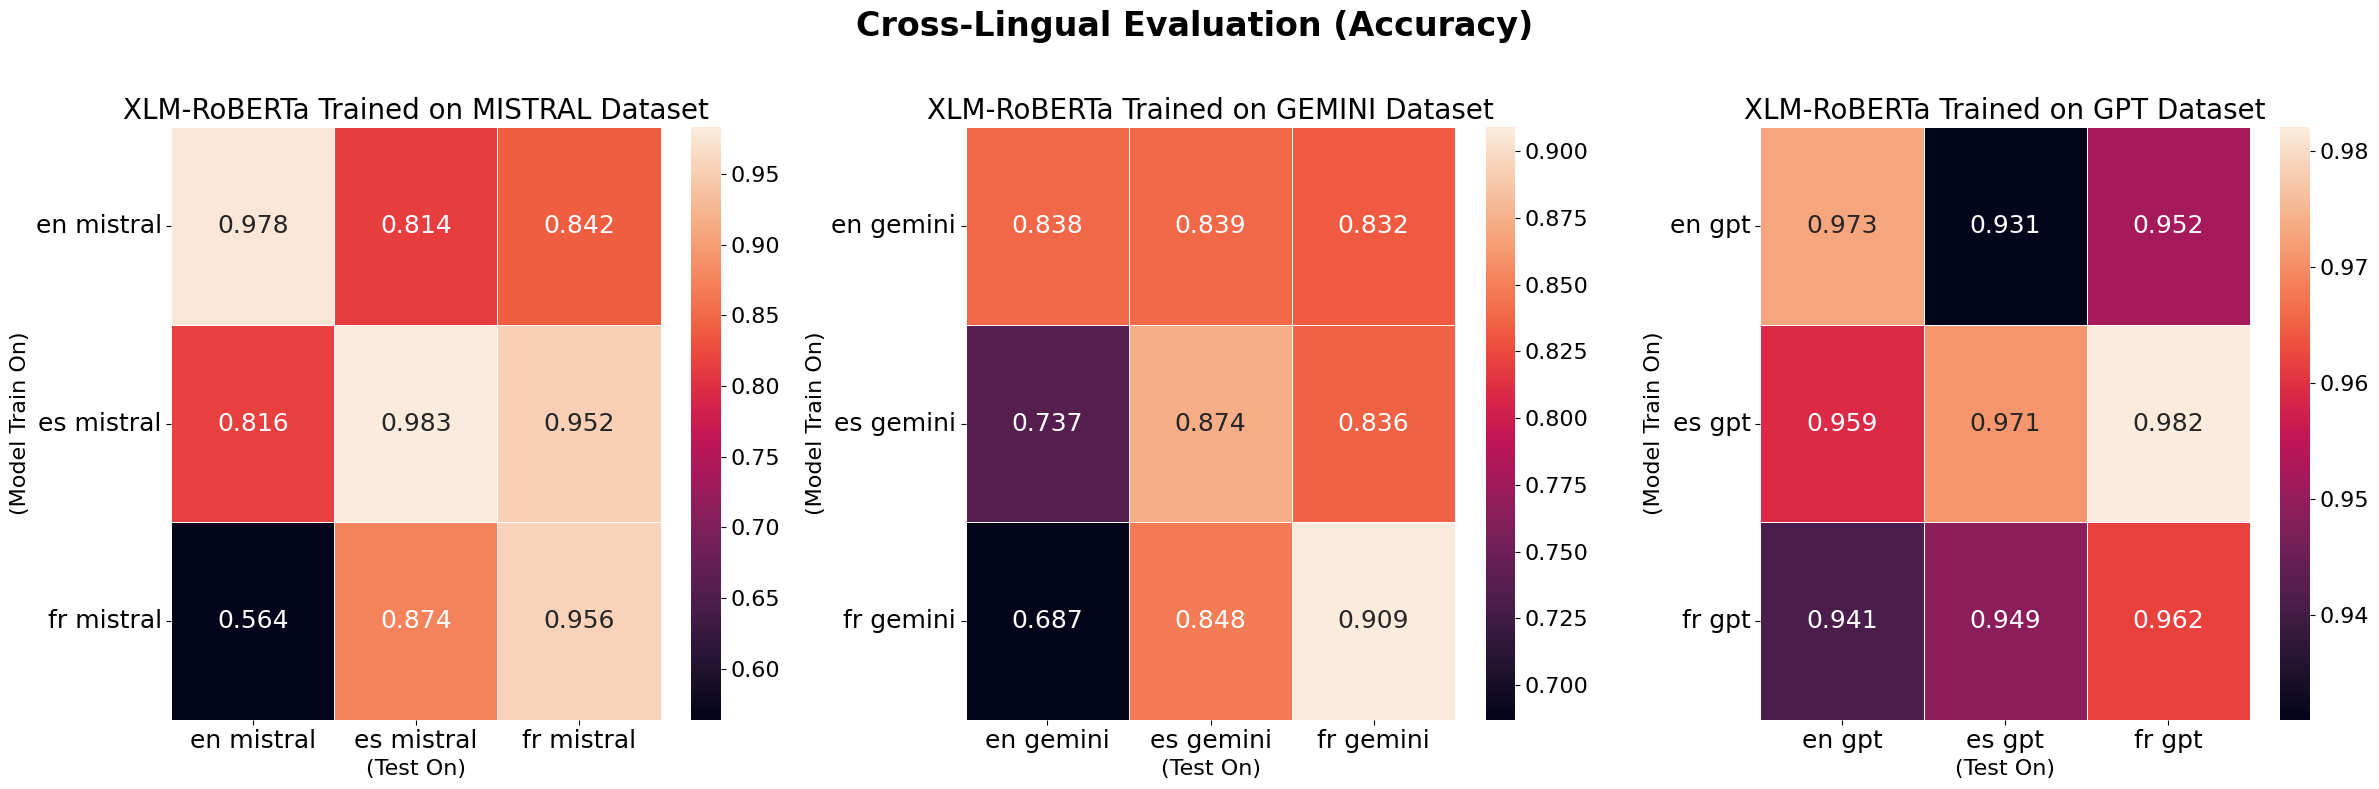

In [32]:
# Load the data from a CSV file
results_df = pd.read_csv('cross_lingual_evaluation_results.csv')

# Define a list of models assuming unique identifiers in your dataset
models = ['mistral', 'gemini', 'gpt']

# Create a custom color map from white to green
gray_green = LinearSegmentedColormap.from_list("gray_green", ["gray", "green"])


# Apply the function to the 'Model Train On' and 'Test on' column
results_df['Model Train On'] = results_df['Model Train On'].apply(modify_model_name)
results_df['Test On'] = results_df['Test On'].apply(modify_model_and_test_name)

# Create a single figure before the loop
fig = plt.figure(figsize=(24, 8))  # Adjusted size for side-by-side layout

# Add a title to the entire figure
fig.suptitle('Cross-Lingual Evaluation (Accuracy)', fontsize=24, weight='bold')

# Loop over models
for i, model in enumerate(models):
    # Filter data for the current model
    model_data = results_df[results_df['Model Train On'].str.contains(model)]
    heatmap_data = model_data.pivot(index="Model Train On", columns="Test On", values="Accuracy")

    # Add subplot to the figure created before the loop
    ax = fig.add_subplot(1, len(models), i + 1)  # Subplot for each model side by side
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", linewidths=.5, 
                annot_kws={"size": 18}, ax=ax)
    ax.set_title(f'XLM-RoBERTa Trained on {model.upper()} Dataset', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center', fontsize=18)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=18)
    ax.set_ylabel('(Model Train On)', fontsize=16)  
    ax.set_xlabel('(Test On)', fontsize=16)

    # Set colorbar properties to increase font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
plt.savefig('cross_lingual_evaluation_accuracy.png', dpi=300)
plt.show()
